## Загрузка данных

In [1]:
!pip install skorch

     |████████████████████████████████| 193 kB 1.9 MB/s eta 0:00:01


# Определение температуры звезд

Поступила задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным, чем используемые раньше

**Цель проекта:** обучить нейросеть, способную предсказать температуру на поверхности с точностью не меньше 4500 по метрике RMSE.

**Задачи:**
- Загрузить датасет
- Исследовать качество данных, провести предобработку при необходимости
- Проанализировать данные
- Построить Baseline модели
- Улучшить Baseline, перебрав гиперпараметры
- Сделать вывод

In [2]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from skorch import NeuralNetRegressor 

random.seed(0)
np.random.seed(0)
torch.manual_seed(12345)
torch.use_deterministic_algorithms(True)

In [3]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data

Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0               3068          0.002400        0.1700                   16.12   
1               3042          0.000500        0.1542                   16.60   
2               2600          0.000300        0.1020                   18.70   
3               2800          0.000200        0.1600                   16.65   
4               1939          0.000138        0.1030                   20.06   
..               ...               ...           ...                     ...   
235            38940     374830.000000     1356.0000                   -9.93   
236            30839     834042.000000     1194.0000                  -10.63   
237             8829     537493.000000     1423.0000                  -10.73   
238             9235     404940.000000     1112.0000                  -11.23   
239            37882     294903.000000     1783.0000                   -7.80   

     Star type Star color  
0            0        Red  
1            0        Red  
2            0        Red  
3            0        Red  
4            0        Red  
..         ...        ...  
235          5       Blue  
236          5       Blue  
237          5      White  
238          5      White  
239          5       Blue  

[240 rows x 6 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## Предобработка и анализ данных

In [5]:
data = data.rename(columns={"Temperature (K)": "temp",
                   "Luminosity(L/Lo)": "lumin",
                  "Radius(R/Ro)": "radius",
                  "Absolute magnitude(Mv)": "abs_magnit",
                  "Star type": "star_type",
                  "Star color": "star_color"})

Проверим наш датасет на количество пропусков и дупликат

In [6]:
data.isna().sum()

temp          0
lumin         0
radius        0
abs_magnit    0
star_type     0
star_color    0
dtype: int64

In [7]:
data.duplicated().sum()

0

Пропусков и дубликатов в датасете не обнаружено

In [8]:
cat_cols = ['star_type', 'star_color']
num_cols = list(data.columns)
num_cols.remove(cat_cols[0])
num_cols.remove(cat_cols[1])

In [9]:
data.describe()

temp          lumin       radius  abs_magnit   star_type
count    240.000000     240.000000   240.000000  240.000000  240.000000
mean   10497.462500  107188.361635   237.157781    4.382396    2.500000
std     9552.425037  179432.244940   517.155763   10.532512    1.711394
min     1939.000000       0.000080     0.008400  -11.920000    0.000000
25%     3344.250000       0.000865     0.102750   -6.232500    1.000000
50%     5776.000000       0.070500     0.762500    8.313000    2.500000
75%    15055.500000  198050.000000    42.750000   13.697500    4.000000
max    40000.000000  849420.000000  1948.500000   20.060000    5.000000

In [10]:
data['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

In [11]:
data['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Можно заметить, что многие цвета упоминаются несколько раз, так как написаны по-разному, а несут за собой один и тот же смысл. Эту аномалию необходимо исправить

In [12]:
#Для начала переведем все цвета в нижний регситр
data['star_color'] = data['star_color'].str.lower()

#Удалим пробелы справа
data['star_color'] = data['star_color'].str.rstrip()

#Заменим '-' на пробелы 
data['star_color'] = data['star_color'].str.replace('-', ' ')

data['star_color'].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

Построим графики распределений наших числовых параметров

temp


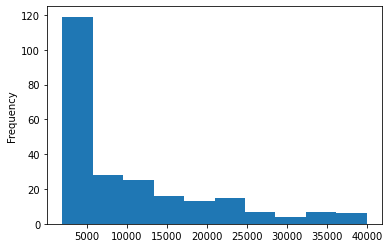

lumin


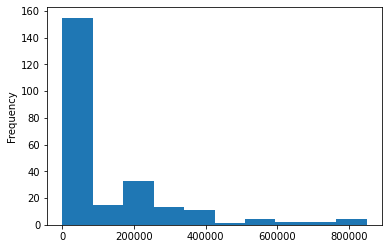

radius


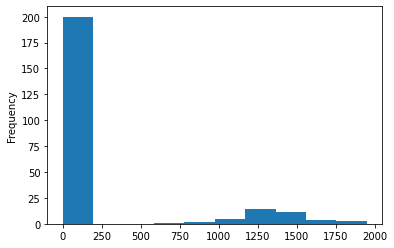

abs_magnit


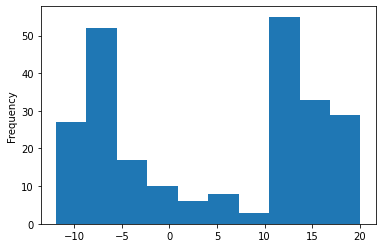

In [13]:
for col in num_cols:
    print(col)
    data[col].plot(kind='hist')
    plt.show()

Построим графики распределений

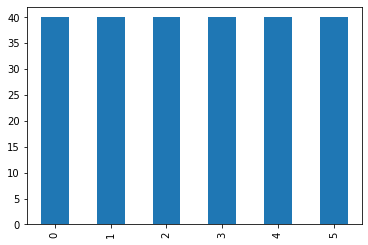

In [14]:
data['star_type'].value_counts().plot(kind='bar');

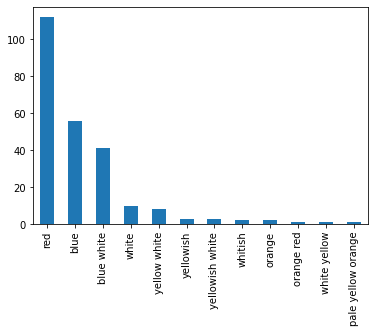

In [15]:
data['star_color'].value_counts().plot(kind='bar');

Заменим редко встречающиеся цвета, чтобы модель реже ошибалась на них из-за их слабой представленности в датасете. Для этого сгруппируем данные по цвету и выберем ближайшую для малых групп группу побольше, опираясь на температуру звезды

In [16]:
data.groupby(by='star_color').agg('mean')['temp']

star_color
blue                  21918.339286
blue white            16659.951220
orange                 4018.000000
orange red             5112.000000
pale yellow orange     7230.000000
red                    3291.785714
white                  9720.300000
white yellow           7100.000000
whitish                8876.000000
yellow white           6466.250000
yellowish              4527.666667
yellowish white       10826.666667
Name: temp, dtype: float64

In [17]:
data = data.replace(['orange red', 'pale yellow orange'], 'orange')
data = data.replace(['orange red', 'pale yellow orange'], 'orange')
data = data.replace(['yellowish white', 'whitish', 'white yellow'], 'white')

In [18]:
data['star_color'].value_counts()

red             112
blue             56
blue white       41
white            16
yellow white      8
orange            4
yellowish         3
Name: star_color, dtype: int64

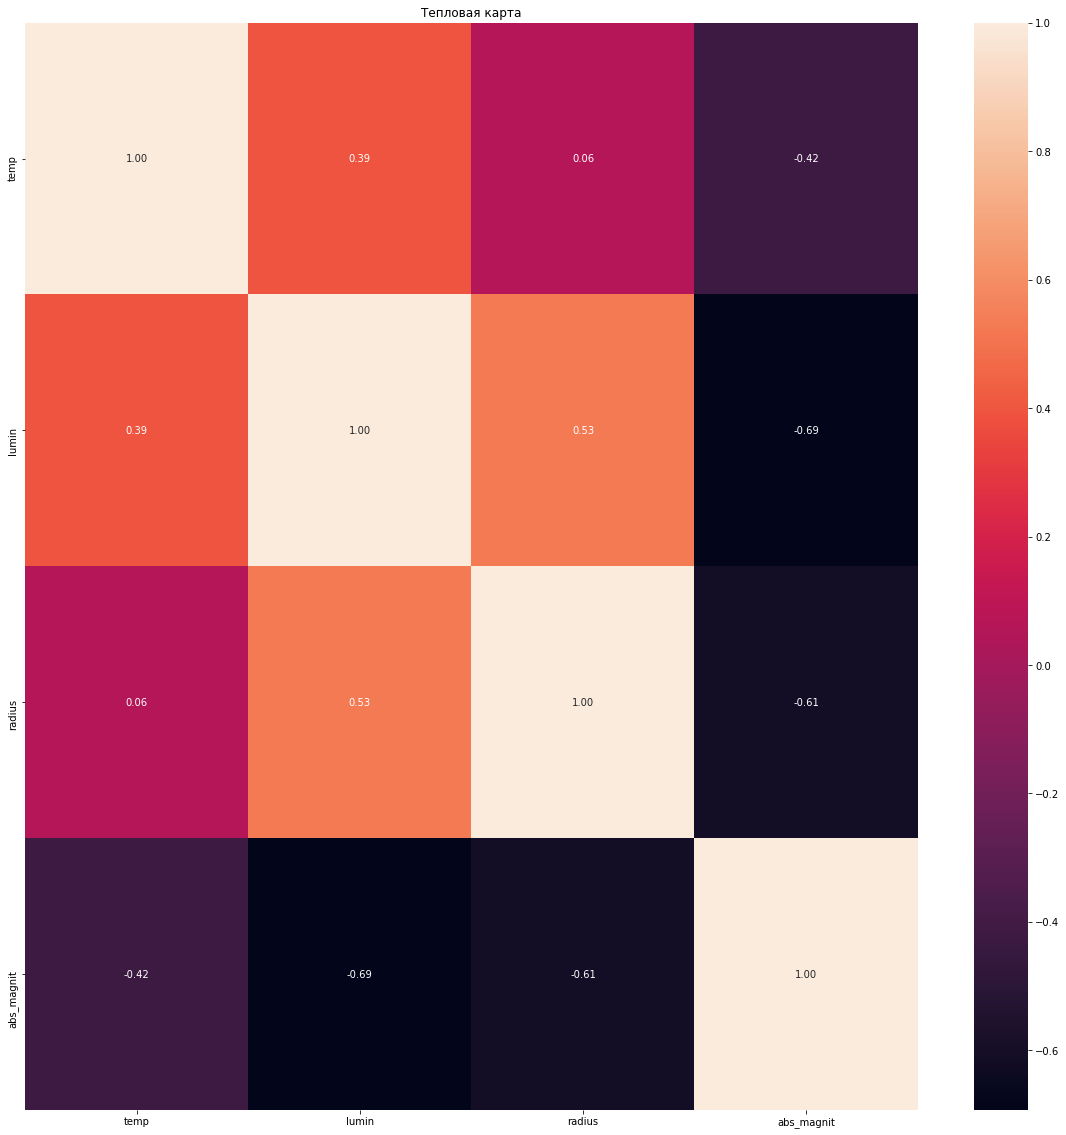

In [19]:
plt.figure(figsize=(20, 20)) # задаём размер графика
sns.heatmap(data[num_cols].corr(), # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='.2f') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

Выделим фичи и таргет

In [20]:
features = data.drop('temp', axis=1)

target = data['temp']

features['star_type'] = features['star_type'].astype('object')

Разобьем датасет на обучающую и тестовую выборки

In [21]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123, stratify=features['star_color'])

In [22]:
cat_cols

['star_type', 'star_color']

Подготовим данные к обучению

In [23]:
pd.options.mode.chained_assignment = None

encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(features_train[cat_cols])
column_names = list(encoder_ohe.get_feature_names())
features_train[column_names] = encoder_ohe.transform(features_train[cat_cols]).toarray()
features_train.drop(cat_cols, axis=1, inplace=True)
features_test[column_names] = encoder_ohe.transform(features_test[cat_cols]).toarray()
features_test.drop(cat_cols, axis=1, inplace=True)

In [24]:
num_cols = ['lumin', 'radius', 'abs_magnit']

In [25]:
scaler = StandardScaler()
features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [26]:
features_train.head()

lumin    radius  abs_magnit  x0_0  x0_1  x0_2  x0_3  x0_4  x0_5  \
13 -0.615398 -0.459802    0.622579   0.0   1.0   0.0   0.0   0.0   0.0   
18 -0.615398 -0.460180    0.914109   0.0   1.0   0.0   0.0   0.0   0.0   
99  0.427017 -0.440932   -0.799703   0.0   0.0   0.0   1.0   0.0   0.0   
36 -0.615390 -0.458403   -0.148779   0.0   0.0   0.0   1.0   0.0   0.0   
32 -0.609417 -0.446704   -0.567435   0.0   0.0   0.0   1.0   0.0   0.0   

    x1_blue  x1_blue white  x1_orange  x1_red  x1_white  x1_yellow white  \
13      0.0            0.0        0.0     1.0       0.0              0.0   
18      0.0            0.0        0.0     1.0       0.0              0.0   
99      1.0            0.0        0.0     0.0       0.0              0.0   
36      0.0            0.0        0.0     0.0       0.0              1.0   
32      0.0            1.0        0.0     0.0       0.0              0.0   

    x1_yellowish  
13           0.0  
18           0.0  
99           0.0  
36           0.0  
32           0.0

In [27]:
print(features_train.shape, features_test.shape)

(180, 16) (60, 16)


In [36]:
X_train = torch.FloatTensor(features_train.values.astype('float32'))
X_test = torch.FloatTensor(features_test.values.astype('float32'))
y_train = torch.FloatTensor(target_train.values.astype('float32'))
y_test = torch.FloatTensor(target_test.values.astype('float32'))

## Построение базовой нейронной сети

In [37]:
class Net(nn.Module):
    def __init__(self, dropout1=0.0, dropout2=0.0):
        super(Net, self).__init__()   
        self.fc1 = nn.Linear(16, 31)
        self.act1 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=dropout1)       
        self.fc2 = nn.Linear(31, 20) 
        self.act2 = nn.LeakyReLU()
        self.fc3 = nn.Linear(20, 1)
        self.act3 = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        return x

Параметры сети

In [38]:
n_in_neurons = 11
n_hidden_neurons_1 = 13
n_hidden_neurons_2 = 2
n_hidden_neurons_3 = 15
n_out_neurons = 1
learning_rate = 5e-2

In [39]:
net = Net()

In [40]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

loss = nn.MSELoss()

num_epochs = 500

In [41]:
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['test'] = []
y_loss['epoch'] = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(X_train).flatten()
            
    loss_value = loss(preds, y_train)
    print(loss_value)
    loss_value.backward()
            
    optimizer.step()
    
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        net.eval()
        y_loss['train'].append(loss_value.item())
        test_preds = net.forward(X_test)
        test_preds = test_preds.squeeze()
        y_loss['test'].append(mean_squared_error(y_test.numpy(), test_preds.detach().numpy()))
        y_loss['epoch'].append(epoch)

tensor(2.1912e+08, grad_fn=<MseLossBackward0>)
tensor(2.1910e+08, grad_fn=<MseLossBackward0>)
tensor(2.1908e+08, grad_fn=<MseLossBackward0>)
tensor(2.1903e+08, grad_fn=<MseLossBackward0>)
tensor(2.1896e+08, grad_fn=<MseLossBackward0>)
tensor(2.1884e+08, grad_fn=<MseLossBackward0>)
tensor(2.1866e+08, grad_fn=<MseLossBackward0>)
tensor(2.1841e+08, grad_fn=<MseLossBackward0>)
tensor(2.1808e+08, grad_fn=<MseLossBackward0>)
tensor(2.1765e+08, grad_fn=<MseLossBackward0>)
tensor(2.1709e+08, grad_fn=<MseLossBackward0>)
tensor(2.1639e+08, grad_fn=<MseLossBackward0>)
tensor(2.1552e+08, grad_fn=<MseLossBackward0>)
tensor(2.1447e+08, grad_fn=<MseLossBackward0>)
tensor(2.1320e+08, grad_fn=<MseLossBackward0>)
tensor(2.1169e+08, grad_fn=<MseLossBackward0>)
tensor(2.0992e+08, grad_fn=<MseLossBackward0>)
tensor(2.0785e+08, grad_fn=<MseLossBackward0>)
tensor(2.0547e+08, grad_fn=<MseLossBackward0>)
tensor(2.0273e+08, grad_fn=<MseLossBackward0>)
tensor(1.9962e+08, grad_fn=<MseLossBackward0>)
tensor(1.9611

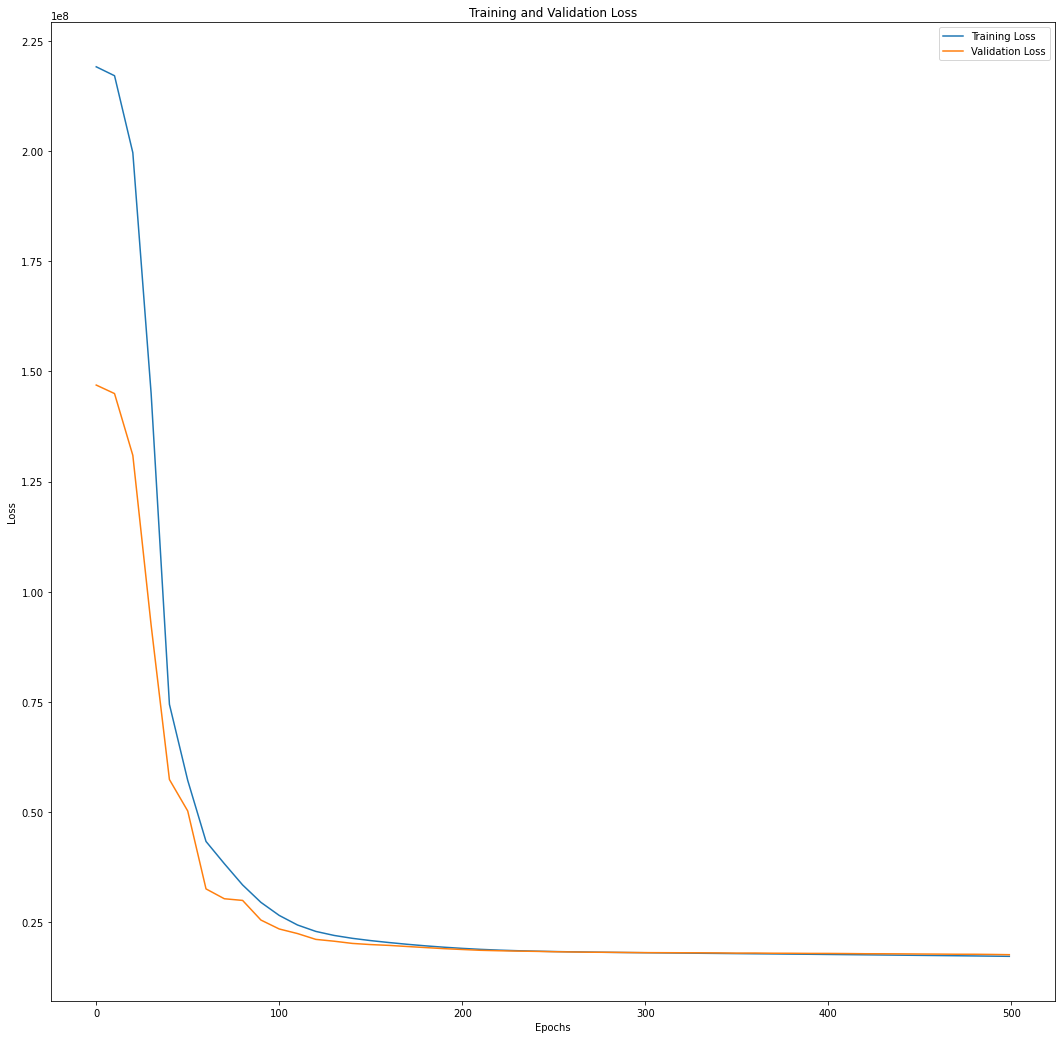

In [42]:
plt.figure(figsize=(18, 18))
plt.plot(y_loss['epoch'], y_loss['train'], label='Training Loss')
plt.plot(y_loss['epoch'], y_loss['test'], label='Validation Loss')
 

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

In [43]:
net.eval()
test_preds = net.forward(X_test)
print(test_preds)
test_preds = test_preds.squeeze()
print(mean_squared_error(y_test.numpy(), test_preds.detach().numpy(), squared=False))

tensor([[ 8511.4092],
        [ 3290.1511],
        [19707.4316],
        [ 5556.2183],
        [11864.8145],
        [29910.3242],
        [20900.7617],
        [ 2433.0166],
        [ 4676.2803],
        [ 3537.8022],
        [ 3337.6375],
        [10066.7168],
        [ 2959.8127],
        [22130.2344],
        [28709.9922],
        [20120.1836],
        [ 4286.4570],
        [ 3221.6079],
        [21721.5781],
        [ 3383.6824],
        [ 9606.9736],
        [18970.9453],
        [11249.8672],
        [ 3139.0212],
        [ 3093.2590],
        [22007.6328],
        [ 4801.1841],
        [ 3166.6399],
        [ 7000.0562],
        [ 3676.2339],
        [20719.6914],
        [ 2948.3669],
        [19510.8086],
        [20726.4004],
        [20416.1367],
        [ 4443.8877],
        [20591.0371],
        [ 2472.6301],
        [11282.4746],
        [16498.1719],
        [ 2666.7866],
        [ 6722.1880],
        [22007.6348],
        [11505.2783],
        [11535.9258],
        [ 

In [44]:
def pred_true_plot(true, pred, n_values):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    ax.bar(x=target_test.index[:n_values], height=true[:n_values], width=3, align='center', label='Y_true')
    ax.bar(x=target_test.index[:n_values], height=pred[:n_values], width=1.5, align='center', label='Y_pred')
    ax.legend()

    plt.tight_layout()
    plt.show()

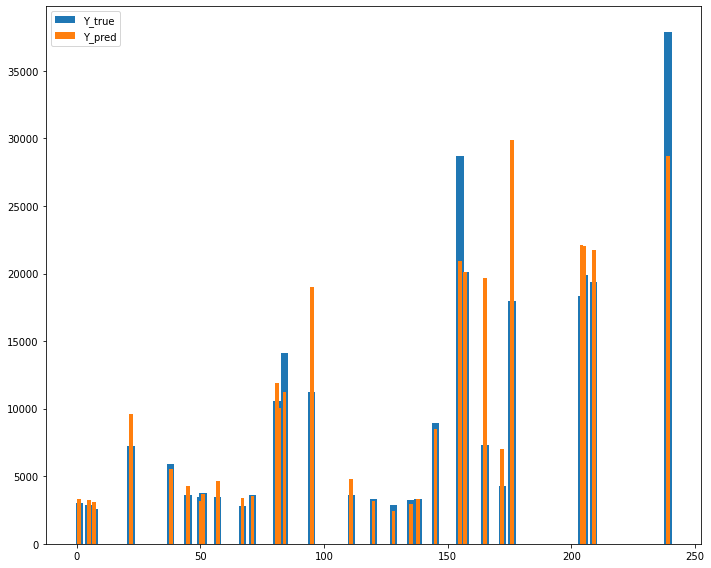

In [45]:
pred_true_plot(y_test.numpy(), test_preds.detach().numpy(), 30)

Опираясь на полученный график можно сказать, что с некоторыми случаями сеть справилась вполне неплохо, а с другими не очень хорошо, это может быть связано с тем, что некоторые виды звезд представлены в записях лишь по одному разу

## Улучшение нейронной сети

In [46]:
net = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss,
    max_epochs=10,
    optimizer=torch.optim.Adam,
    optimizer__lr=.05
)

Зададим параметры для GridSearch

In [47]:
params = {
    'optimizer__lr': [0.01, 0.05, 0.025],
    'max_epochs': [500, 550, 600],
    'module__dropout1' : [0, 0.1, 0.2],
    'module__dropout2' : [0, 0.1, 0.2]
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train.reshape(-1,1))

  epoch      train_loss      valid_loss     dur
-------  --------------  --------------  ------
      1  183619056.0000  144931712.0000  0.0048
      2  183619056.0000  144931712.0000  0.0039
      3  183619056.0000  144931712.0000  0.0034
      4  183619056.0000  144931712.0000  0.0032
      5  183619056.0000  144931712.0000  0.0033
      6  183619056.0000  144931712.0000  0.0028
      7  183619056.0000  144931712.0000  0.0034
      8  183619056.0000  144931712.0000  0.0032
      9  183619056.0000  144931712.0000  0.0034
     10  183619056.0000  144931712.0000  0.0031
     11  183619056.0000  144931712.0000  0.0032
     12  183619056.0000  144931712.0000  0.0031
     13  183619056.0000  144931712.0000  0.0032
     14  183619056.0000  144931712.0000  0.0032
     15  183619056.0000  144931712.0000  0.0032
     16  183619056.0000  144931712.0000  0.0032
     17  183619056.0000  144931712.0000  0.0030
     18  183619056.0000  144931712.0000  0.0031
     19  183619056.0000  144931712.0000 

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Net'>,
),
             param_grid={'max_epochs': [500, 550, 600],
                         'module__dropout1': [0, 0.1, 0.2],
                         'module__dropout2': [0, 0.1, 0.2],
                         'optimizer__lr': [0.01, 0.05, 0.025]},
             refit=False, scoring='neg_mean_squared_error')

Выведем результат и лучшие гиперпараметры

In [48]:
print(gs.best_score_, gs.best_params_)
#-23444718.0 {'max_epochs': 550, 'module__dropout1': 0.2, 'module__dropout2': 0.2, 'optimizer__lr': 0.05}

-23489613.333333332 {'max_epochs': 550, 'module__dropout1': 0.2, 'module__dropout2': 0.1, 'optimizer__lr': 0.05}


Строим сеть с полученными параметрами

In [49]:
net = NeuralNetRegressor(
    Net,
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    max_epochs=550,
    optimizer__lr=0.05, 
    module__dropout1=0.2,
    module__dropout2=0.2,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [50]:
net.fit(X_train, y_train.reshape(-1,1))
test_preds = net.predict(X_test)

  epoch      train_loss      valid_loss     dur
-------  --------------  --------------  ------
      1  198659408.0000  300942560.0000  0.0531
      2  198642680.8889  300858368.0000  0.0054
      3  198579470.2222  300621920.0000  0.0047
      4  198400961.7778  300118912.0000  0.0050
      5  198024039.1111  299197664.0000  0.0050
      6  197360494.2222  297648320.0000  0.0046
      7  196217262.2222  295238272.0000  0.0046
      8  194471655.1111  291672896.0000  0.0641
      9  191952082.6667  286585664.0000  0.0050
     10  188272865.7778  279635296.0000  0.0047
     11  183774325.3333  270504896.0000  0.0045
     12  177029438.2222  258832384.0000  0.0045
     13  169610410.6667  244360048.0000  0.0046
     14  160711626.6667  226832480.0000  0.0046
     15  148452236.4444  206277408.0000  0.0051
     16  136321575.1111  183187536.0000  0.0046
     17  123094641.7778  158833216.0000  0.0043
     18  109142688.0000  134145792.0000  0.0045
     19  96308142.2222  110003808.0000  

Посчитаем метрику RMSE:

In [51]:
mean_squared_error(y_test, test_preds, squared=False)

4733.32

Метрику получилось улучшить, но лишь немного

In [52]:
test_preds = test_preds.squeeze()

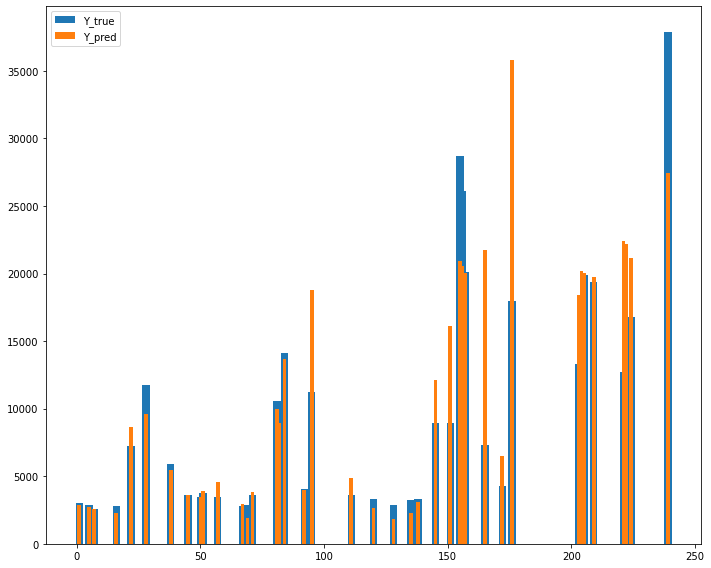

In [53]:
pred_true_plot(y_test.detach().numpy(), test_preds, 40)

В результате улучшения нейронной сети получилось незначительно улучшить метрику RMSE, возможно потому что архитектура исходной сети не позволяет добиться большего результата.

## Выводы

В ходе выполнения проекта была реализована нейронная сеть для определения температуры звезд. С помощью подбора гиперпараметров метрики качества удалось улучшить и они составили 5914(RMSE).